In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

!pip install -q nilearn
!pip install -q nibabel
!pip install -q neuromaps

In [5]:
##montar drive para que colab lo vea. Nota: pedirá permisos de usuario
# from google.colab import drive
# drive.mount('/content/drive/')


###correr esta línea para chequear carpeta con la data
#!ls -R /content/drive/Mydrive

##Cambiar el directorio
import os
local = os.getcwd()
os.chdir("/content/drive/Mydrive/neuroscience_guatemala")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Mydrive/neuroscience_guatemala'

In [2]:
!ls -R /content/drive

ls: cannot access '/content/drive/Mydrive': No such file or directory


In [24]:
###########cargar nombres de áreas

##El orden original es LLLRRR. Lo cambiamos a LRLRLR (es lo más usual)
AAL_labels_unsorted = pd.read_csv("symmetrized_AAL_labels.txt")["label"].values ###labels as array
left = AAL_labels_unsorted[:45]
right = AAL_labels_unsorted[45:][::-1]


####the usual order is ...LRLRLR...
AAL_labels_sorted = np.zeros_like(AAL_labels_unsorted)
AAL_labels_sorted[::2] = left
AAL_labels_sorted[1::2] = right

##imprimir áreas en pantalla
# for i,area in enumerate(AAL_labels_sorted):
#   print(i,area)

(1500, 90)


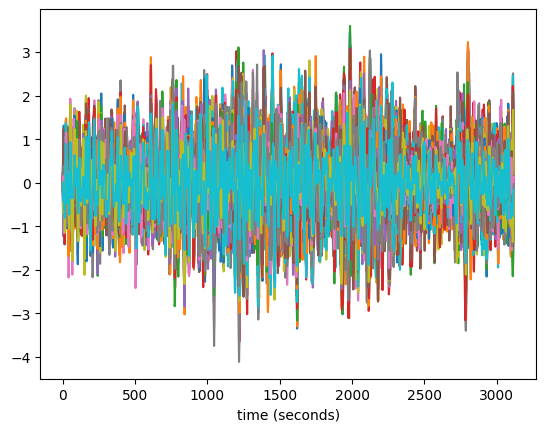

In [17]:
############CARGAR DATA PARCELADA

BOLD_output = 'functional_data/'
TR = 2.08    #fMRI repetition time
a0, b0 = signal.bessel(2, 2 * TR * np.array([0.01, 0.1]), btype = 'bandpass')


###cargar datos de un paciente
BOLD_signals = np.load(BOLD_output +f'BOLD_complete_nonfilt_S20080617AB.npy')
BOLD_filt = signal.filtfilt(a0, b0, BOLD_signals, axis = 0)[:,0:90]
print(BOLD_filt.shape)


time = TR*np.arange(0,len(BOLD_filt),1)

plt.figure(1)
plt.clf()
plt.plot(time,BOLD_filt)
plt.xlabel("time (seconds)")
plt.show()

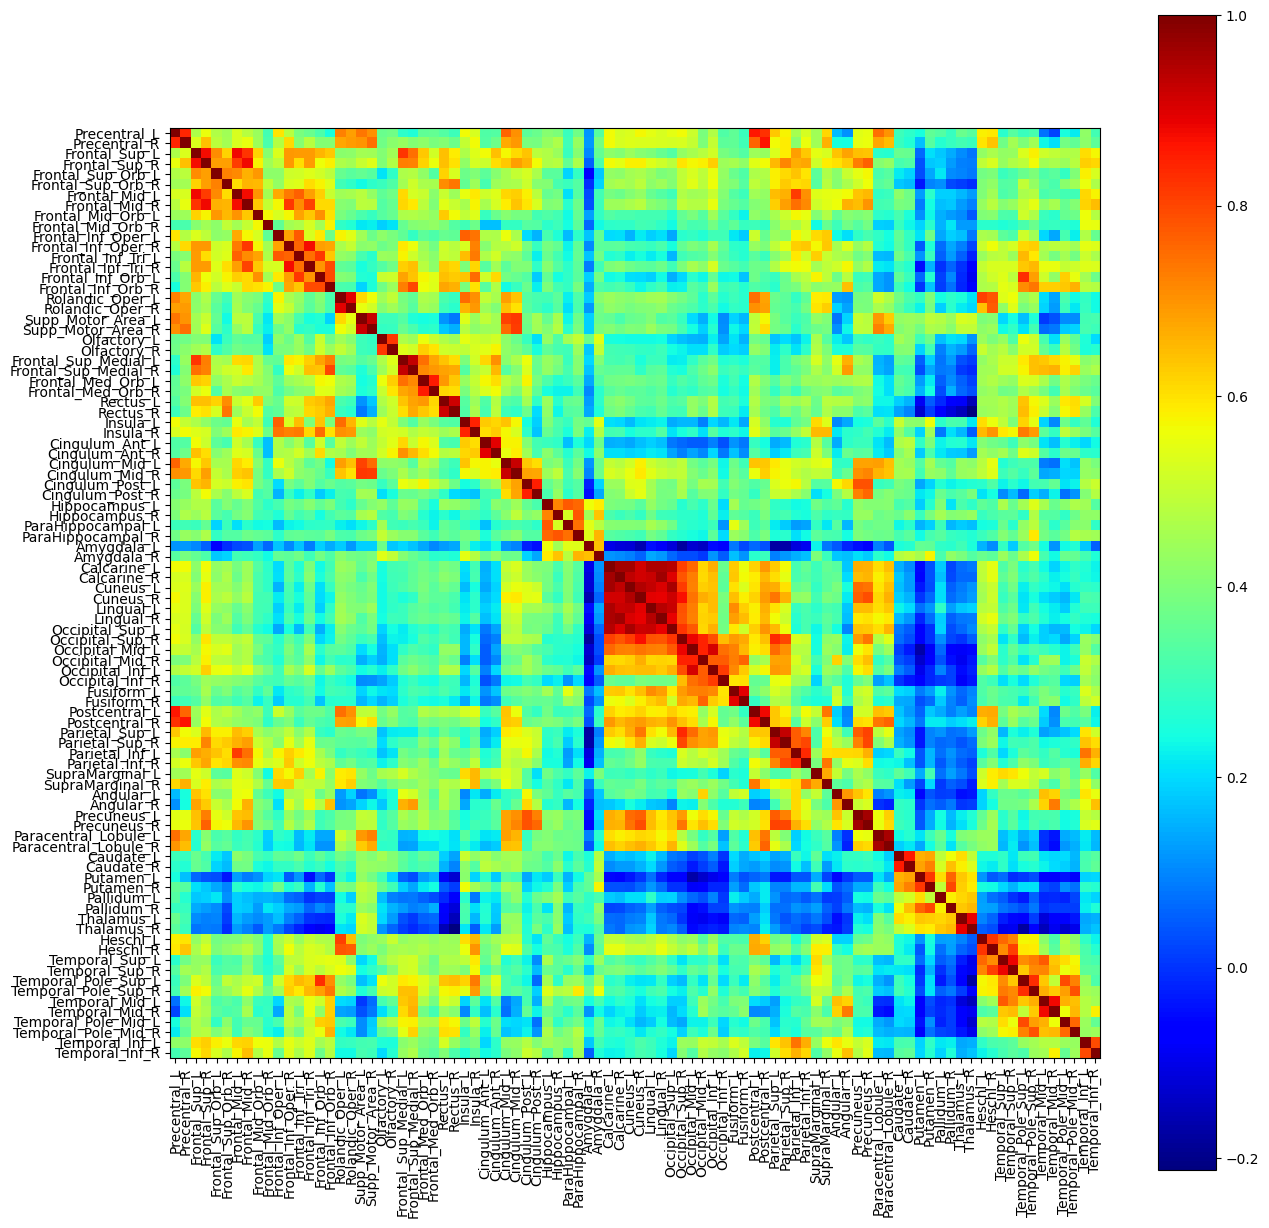

In [30]:
##ver matriz de conectividadd

FC = np.corrcoef(BOLD_filt.T)


colormap="jet"

plt.figure(2,figsize=(15,15))
plt.clf()
plt.imshow(FC,cmap=colormap)
plt.colorbar()

##optional: show areas
plt.xticks(range(len(FC)),AAL_labels_sorted,rotation=90)
plt.yticks(range(len(FC)),AAL_labels_sorted)

plt.show()

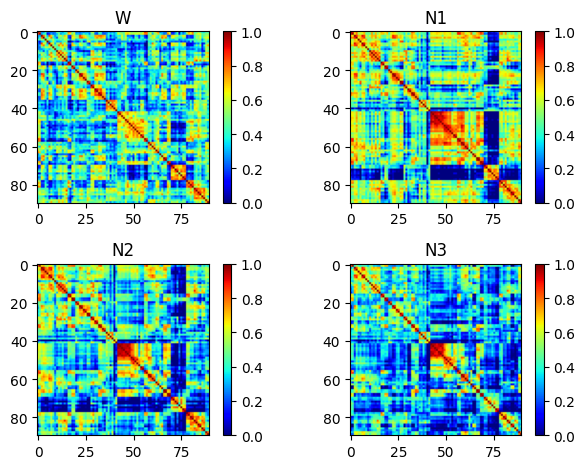

In [39]:
##verlo por etapas del sueño

##vector que nos dice en que etapa del sueño estaba el individuo
vector = np.load(BOLD_output +f'align_stages_S20080617AB.npy')
idx_WAKE = vector == 0
idx_N1 = vector == -2
idx_N2 = vector == -3
idx_N3 = vector == -4


###vamos a ir agregando tiempos en que el individuo estaba en cada etapa

BOLD_WAKE = BOLD_filt[idx_WAKE,:]
BOLD_N1 = BOLD_filt[idx_N1,:]
BOLD_N2 = BOLD_filt[idx_N2,:]
BOLD_N3 = BOLD_filt[idx_N3,:]


##calculamos FCs
FC_W = np.corrcoef(BOLD_WAKE.T)
FC_N1 = np.corrcoef(BOLD_N1.T)
FC_N2 = np.corrcoef(BOLD_N2.T)
FC_N3 = np.corrcoef(BOLD_N3.T)


##mostramos
plt.figure(3)
plt.subplot(221)
plt.title("W")
plt.imshow(FC_W,cmap=colormap,vmin=0,vmax=1)
plt.colorbar()

plt.subplot(222)
plt.title("N1")
plt.imshow(FC_N1,cmap=colormap,vmin=0,vmax=1)
plt.colorbar()

plt.subplot(223)
plt.title("N2")
plt.imshow(FC_N2,cmap=colormap,vmin=0,vmax=1)
plt.colorbar()

plt.subplot(224)
plt.title("N3")
plt.imshow(FC_N3,cmap=colormap,vmin=0,vmax=1)
plt.colorbar()


plt.tight_layout()
plt.show()


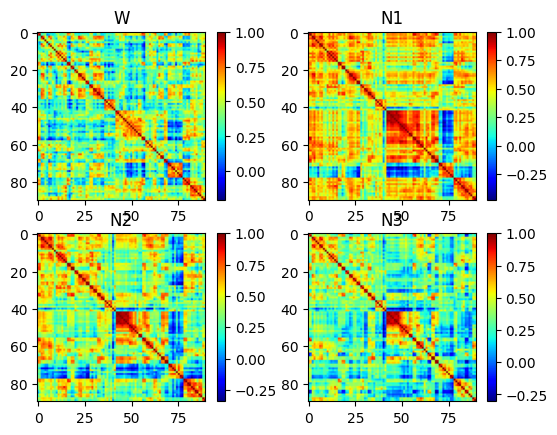

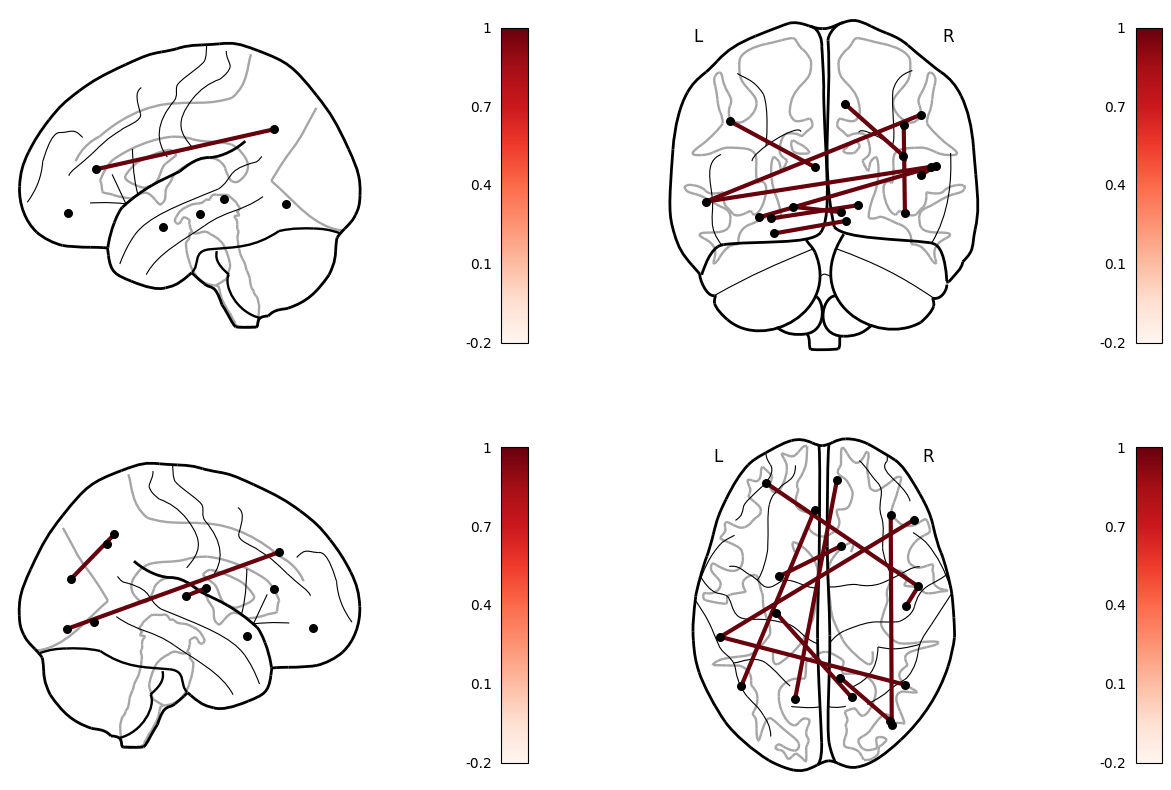

In [46]:
###opcional: ver conectividad en un cerebro de cristal.
#ejercicio: plotear la conectividad de corteza prefrontal con el resto del cerebro

import nibabel as nib
from nilearn import datasets, plotting, image

def matrix_recon(x,N=82):
    """
    Function to reconstruct a connectivity matrix from its vectorized form.

    Inputs:
        x: numpy array, vector with connectivity values.
    Output:
        matrix: numpy array, connectivity matrix.

    """
    nnodes = N

    matrix = np.zeros((nnodes, nnodes))
    matrix[np.triu_indices(N,k=0)] = x
    matrix = matrix + matrix.T  # Ensure symmetry
    np.fill_diagonal(matrix, matrix.diagonal() / 2)
    return(matrix)


##funcion que transforma ordenes de una matriz
def llrr_2_lrlr(array):
    out = np.zeros_like(array)
    out[::2] = array[:45]
    out[1::2] = array[45:][::-1]
    return out


coord_path  = "functional_data/Node_AAL82.txt"                     # (116 × 3) MNI coords
labels_path = "functional_data/ROI_MNI_V4.csv"

coords_all = pd.read_csv(coord_path,sep="\t").iloc[:,:3].values
AAL_labels= pd.read_csv(labels_path)["label"]


conn_full = np.random.uniform(size=(82,82)) ##notar la dimensionalidad




iu, ju        = np.triu_indices_from(conn_full, k=0)            # upper‑tri indices
edge_weights  = conn_full[iu, ju]

###here control for how many you want to display
top_idx     = np.argsort(edge_weights)[::-1][:10]
edges         = [(iu[k], ju[k], edge_weights[k]) for k in top_idx]

nodes_to_keep = sorted({i for i, j, _ in edges} | {j for i, j, _ in edges})
n_keep        = len(nodes_to_keep)

adj_top = np.zeros((n_keep, n_keep), dtype=float)

for i, j, w in edges:
    ii = nodes_to_keep.index(i)
    jj = nodes_to_keep.index(j)
    adj_top[ii, jj] = adj_top[jj, ii] = w

# rescale weights to 0–1?
adj_top /= adj_top.max()



###coordinates of edges to show
coords_keep = coords_all[nodes_to_keep]


fig, axes = plt.subplots(2, 2, figsize=(15, 10),num=1)
fig.clf()
views = ['l', 'y', 'r', 'z']

for ax, view in zip(axes.ravel(), views):
    disp = plotting.plot_connectome(
        adjacency_matrix=adj_top,
        node_coords=coords_keep,
        node_color='black',
        node_size=30,
        edge_cmap='Reds',
        edge_vmin=-0.2,
        edge_vmax=1,
        display_mode=view,
        axes=ax,                 # <- tell nilearn to use this subplot
        colorbar=True,          # disable extra colorbars per view
        alpha=1,
        edge_kwargs = {"linewidth":3}
    )


plt.subplots_adjust(wspace=-0.005, hspace=-0.005)


# plt.savefig('glass_nodes.svg')
